=== Métricas por SKU y método (ordenado por sMAPE) ===
  sku  metodo      MAE     RMSE      sMAPE  nivel_final
SKU-A     TSB 0.962003 1.216195 178.625182     0.691606
SKU-A Croston 0.945779 1.213810 179.285328     0.662403
SKU-A     SBA 0.927379 1.211951 180.052244     0.629282
SKU-B Croston 1.552342 2.619247 194.189342     0.798648
SKU-B     SBA 1.523058 2.622111 194.446656     0.758716
SKU-B     TSB 1.321939 2.657958 196.300471     0.484463
SKU-C     TSB 0.951638 1.316729 187.333006     0.721931
SKU-C Croston 0.755109 1.282559 191.034391     0.453936
SKU-C     SBA 0.738465 1.282198 191.388857     0.431240
SKU-D Croston 1.187989 2.362294 197.593570     0.566473
SKU-D     SBA 1.164701 2.364330 197.705768     0.538149
SKU-D     TSB 1.034140 2.381959 198.349804     0.379360
SKU-E     TSB 0.704244 0.812423 186.321800     0.596696
SKU-E Croston 0.527362 0.747664 190.771079     0.355494
SKU-E     SBA 0.514328 0.745761 191.144762     0.337719

=== Recomendaciones de Inventario (por SKU) ===


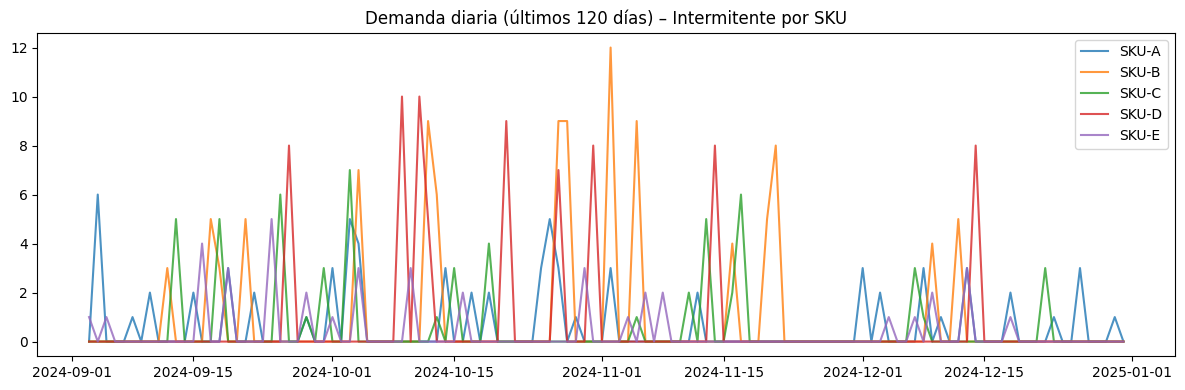

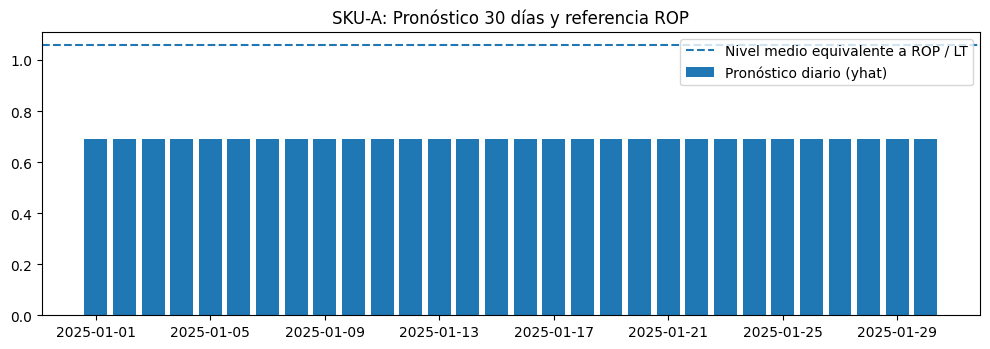

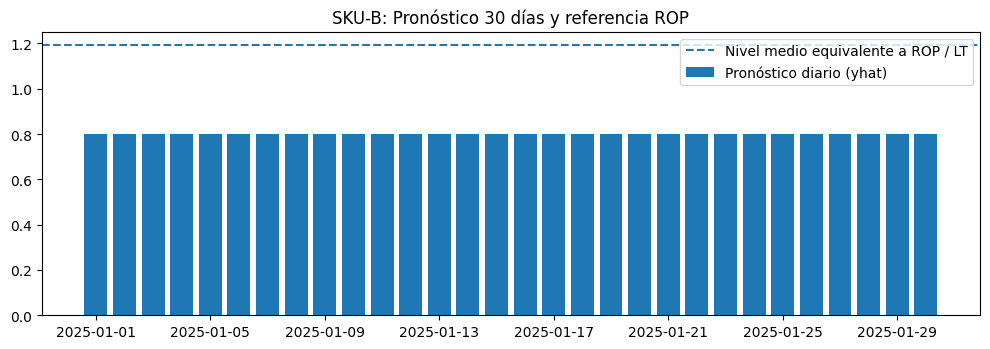

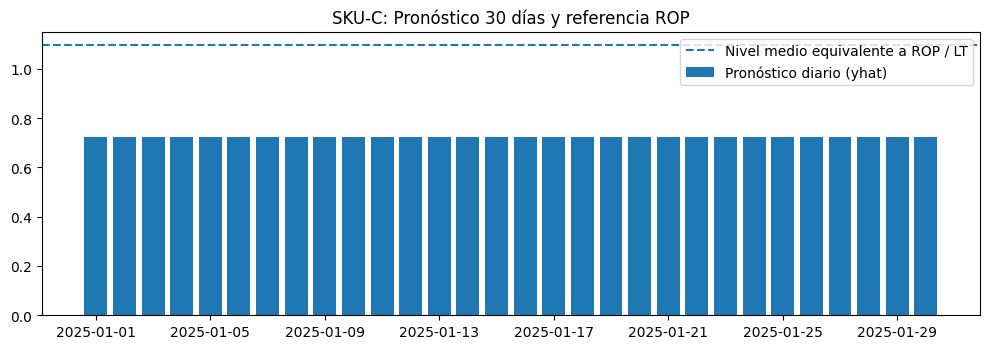

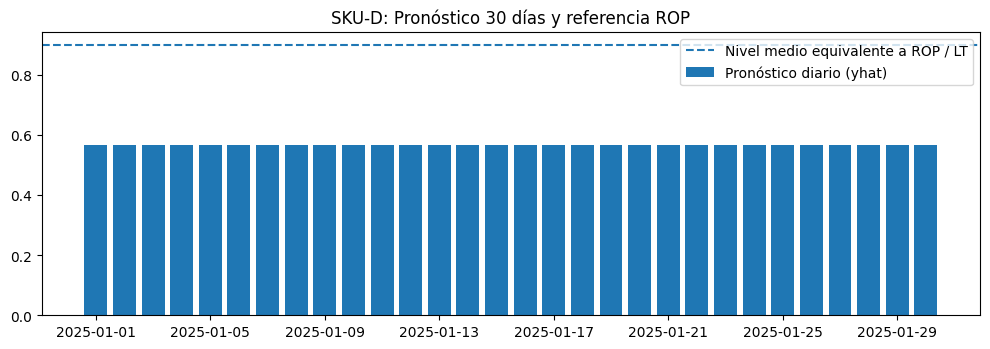

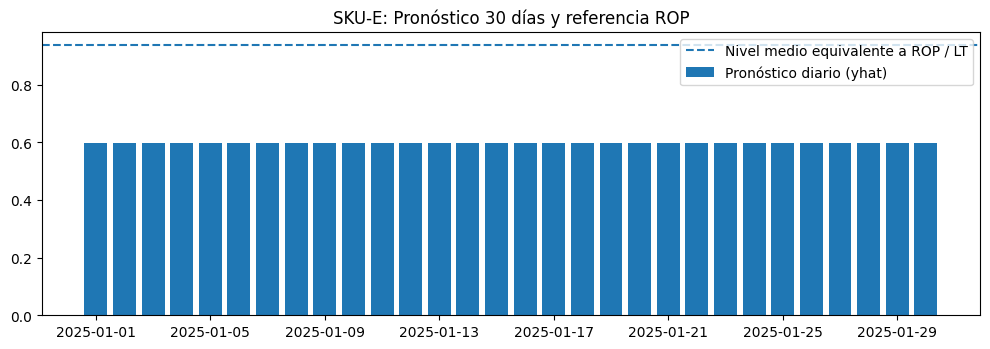

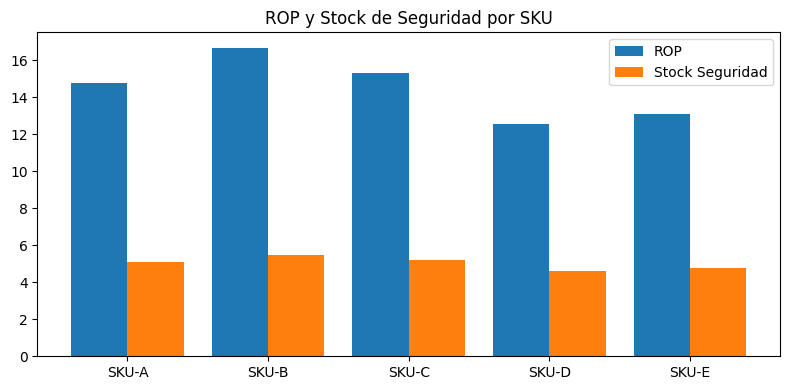


=== Tabla resumen (export-ready) ===
  sku metodo_mejor  MAE  RMSE  sMAPE  nivel_final  demanda_media_diaria_LT  mean_d_LT  std_d_LT   SS   ROP   EOQ
SKU-A          TSB 0.96  1.22 178.63        0.692                    0.692       9.68      3.11 5.12 14.80 112.0
SKU-B      Croston 1.55  2.62 194.19        0.799                    0.799      11.18      3.34 5.50 16.68 121.0
SKU-C          TSB 0.95  1.32 187.33        0.722                    0.722      10.11      3.18 5.23 15.34 115.0
SKU-D      Croston 1.19  2.36 197.59        0.566                    0.566       7.93      2.82 4.63 12.56 102.0
SKU-E          TSB 0.70  0.81 186.32        0.597                    0.597       8.35      2.89 4.75 13.11 104.0


In [1]:
# =============================================================================
# UNA SOLA CELDA – Forecasting de Demanda Intermitente + ROP & Stock Seguridad
# Métodos: Croston, SBA (Syntetos–Boylan), TSB (Teunter–Syntetos–Babai)
# Sin Prophet, solo NumPy/Pandas/Matplotlib (compatibles con Colab actual)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(7)

# =========================
# 1) Simulación de datos
# =========================
# - 5 SKUs con demanda intermitente (muchos ceros)
# - 2023-01-01 a 2024-12-31 (2 años)
# - Distintas probabilidades de ocurrencia y tamaños de lote

fechas = pd.date_range("2023-01-01", "2024-12-31", freq="D")
SKUS = ["SKU-A", "SKU-B", "SKU-C", "SKU-D", "SKU-E"]

def sim_intermittent_series(dates, p_occ, mean_size, weekly_boost=0.0):
    # p_occ: prob de que haya venta (>0) en el día
    # mean_size: tamaño medio de la venta (geométrico/poisson mixto)
    dow = dates.dayofweek.values
    # incremento leve lunes-viernes si weekly_boost>0
    adj = 1.0 + weekly_boost * np.isin(dow, [0,1,2,3,4])  # boost laborable
    occ = (np.random.rand(len(dates)) < (p_occ * adj)).astype(int)
    # tamaño de pedido cuando ocurre (geométrico suavizado)
    size = np.random.poisson(lam=max(0.1, mean_size), size=len(dates)) + \
           np.random.binomial(1, 0.3, size=len(dates))
    return occ * size

data = []
params = {
    "SKU-A": (0.20, 2.5, 0.10),
    "SKU-B": (0.08, 6.0, 0.05),
    "SKU-C": (0.12, 3.0, 0.00),
    "SKU-D": (0.05, 9.0, 0.00),
    "SKU-E": (0.15, 1.8, 0.10),
}
for sku in SKUS:
    p, m, wb = params[sku]
    series = sim_intermittent_series(fechas, p, m, weekly_boost=wb)
    # Introducimos 2 campañas con pico para realismo
    bf = (fechas >= "2023-11-20") & (fechas <= "2023-11-30")
    spring = (fechas >= "2024-04-10") & (fechas <= "2024-04-20")
    series = series + np.where(bf, np.random.poisson(2, size=len(fechas)), 0)
    series = series + np.where(spring, np.random.poisson(1, size=len(fechas)), 0)
    data.append(pd.DataFrame({"ds": fechas, "sku": sku, "y": series.astype(int)}))

df = pd.concat(data, ignore_index=True)

# =========================
# 2) Split Train / Test
# =========================
h_test = 90  # últimos 90 días como test
df["ds"] = pd.to_datetime(df["ds"])
max_date = df["ds"].max()
cutoff = max_date - pd.Timedelta(days=h_test)
train = df[df["ds"] <= cutoff].copy()
test  = df[df["ds"] >  cutoff].copy()

# ===================================================
# 3) Métodos para demanda intermitente
#    Referencias clásicas:
#    - Croston (1972)
#    - SBA: Syntetos & Boylan (2005) -> corrección de sesgo
#    - TSB: Teunter, Syntetos & Babai (2011) -> suaviza prob y tamaño
# ===================================================

def croston(y, alpha=0.1, variant="croston"):
    """
    y: array de demanda (no negativa) con ceros frecuentes.
    variant: 'croston', 'sba', 'tsb'
    Devuelve pronóstico por período (vector) del mismo largo que y.
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    # Inter-arrival times y tamaños
    z = np.zeros(n)  # tamaños en períodos con demanda
    p = np.zeros(n)  # intervalo entre demandas
    q = 0           # contador de intervalos
    first = True

    for t in range(n):
        if y[t] > 0:
            if first:
                z[t] = y[t]
                p[t] = 1
                first = False
            else:
                z[t] = alpha * y[t] + (1 - alpha) * z[t-1]
                p[t] = alpha * (q+1) + (1 - alpha) * p[t-1]
            q = 0
        else:
            if t > 0:
                z[t] = z[t-1]
                p[t] = p[t-1]
            q += 1

    # Pronóstico base Croston: z_hat / p_hat
    eps = 1e-12
    croston_f = z / np.maximum(p, eps)

    if variant == "croston":
        f = croston_f
    elif variant == "sba":
        # Syntetos-Boylan Adjustment: (1 - alpha/2) * (z/p)
        f = (1 - alpha/2.0) * croston_f
    elif variant == "tsb":
        # TSB: suaviza probabilidad de demanda y tamaño por separado
        # Re-implementación: estimamos prob y tamaño con EWMA
        p_hat = np.zeros(n)
        z_hat = np.zeros(n)
        for t in range(n):
            demand_occurs = 1.0 if y[t] > 0 else 0.0
            if t == 0:
                p_hat[t] = demand_occurs
                z_hat[t] = y[t] if y[t] > 0 else 0.0
            else:
                p_hat[t] = alpha * demand_occurs + (1 - alpha) * p_hat[t-1]
                z_hat[t] = alpha * (y[t] if y[t] > 0 else z_hat[t-1]) + (1 - alpha) * z_hat[t-1]
                # Nota: cuando y[t]==0 usamos el último z_hat (alternativa: no actualizar)
        f = p_hat * z_hat
    else:
        raise ValueError("variant debe ser 'croston', 'sba' o 'tsb'")

    # Reemplazo de NaNs/infs
    f = np.where(np.isfinite(f), f, 0.0)
    return f

def forecast_fixed_horizon(last_level, h):
    """Extiende el último pronóstico constante por h pasos."""
    return np.full(h, max(0.0, float(last_level)))

def sMAPE(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1.0, denom)
    return np.mean(2.0 * np.abs(y_true - y_pred) / denom) * 100.0

def MAE(y_true, y_pred):
    return float(np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))))

def RMSE(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

# ===================================================
# 4) Entrenamiento + Selección de método por SKU
# ===================================================
results = []
forecasts_all = []

alpha = 0.1  # factor de suavizado

for sku in SKUS:
    tr = train[train["sku"] == sku].sort_values("ds")
    te = test [test ["sku"] == sku].sort_values("ds")

    y_tr = tr["y"].values
    y_te = te["y"].values

    # Pronóstico in-sample (1 paso adelante) y nivel final
    f_croston = croston(y_tr, alpha=alpha, variant="croston")
    f_sba     = croston(y_tr, alpha=alpha, variant="sba")
    f_tsb     = croston(y_tr, alpha=alpha, variant="tsb")

    # Usamos el último nivel como base para horizonte futuro (constante)
    last_c = f_croston[-1] if len(f_croston) else 0.0
    last_s = f_sba[-1]     if len(f_sba) else 0.0
    last_t = f_tsb[-1]     if len(f_tsb) else 0.0

    # Generamos pronóstico para horizonte test + 30 días extra
    h = len(y_te) + 30
    fc_c = forecast_fixed_horizon(last_c, h)
    fc_s = forecast_fixed_horizon(last_s, h)
    fc_t = forecast_fixed_horizon(last_t, h)

    # Métricas en ventana de test (comparando primeros len(y_te) de cada forecast)
    yhat_c = fc_c[:len(y_te)]
    yhat_s = fc_s[:len(y_te)]
    yhat_t = fc_t[:len(y_te)]

    metrics = []
    for name, yhat in [("Croston", yhat_c), ("SBA", yhat_s), ("TSB", yhat_t)]:
        metrics.append({
            "sku": sku,
            "metodo": name,
            "MAE": MAE(y_te, yhat),
            "RMSE": RMSE(y_te, yhat),
            "sMAPE": sMAPE(y_te, yhat),
            "nivel_final": {"Croston":last_c,"SBA":last_s,"TSB":last_t}[name]
        })

    # Elegimos mejor método por sMAPE (puedes cambiar a MAE/RMSE)
    best = sorted(metrics, key=lambda d: d["sMAPE"])[0]
    results.extend(metrics)

    # Guardamos pronóstico futuro (solo del mejor) para próximos 30 días
    if best["metodo"] == "Croston":
        fc_future = fc_c
    elif best["metodo"] == "SBA":
        fc_future = fc_s
    else:
        fc_future = fc_t

    fc_df = pd.DataFrame({
        "ds": pd.date_range(te["ds"].min(), periods=len(fc_future), freq="D"),
        "sku": sku,
        "yhat": fc_future
    })
    forecasts_all.append((sku, fc_df, best))

metrics_df = pd.DataFrame(results).sort_values(["sku","sMAPE"])
print("=== Métricas por SKU y método (ordenado por sMAPE) ===")
print(metrics_df.to_string(index=False))

# ===================================================
# 5) Inventario: ROP y Stock de Seguridad
#    Supuestos simples de política (R,Q) con lead time L.
# ===================================================
# Parámetros (ajusta según tu negocio):
LEAD_TIME_DAYS = 14            # días de reabastecimiento
SERVICE_LEVEL  = 0.95          # nivel de servicio objetivo
Z = 1.645                       # z-score aprox para 95%
HOLDING_RATE = 0.20            # % anual del coste como costo de tenencia (para EOQ, opcional)
ORDER_COST  = 50.0             # coste por orden (opcional EOQ)
UNIT_COST   = 10.0             # coste unitario (opcional EOQ)

planning_rows = []
plot_frames = []

for sku, fc_df, best in forecasts_all:
    # Pronóstico futuro empieza en el primer día de test; separamos:
    fc_future_30 = fc_df[fc_df["ds"] > test["ds"].max()].head(30).copy()
    if fc_future_30.empty:
        # Si el test es muy corto por alguna razón, tomamos últimos 30 del fc
        fc_future_30 = fc_df.tail(30).copy()

    # Demanda esperada diaria (lambda_t). Para inventario usamos
    # la ventana de protección = LEAD_TIME_DAYS (revisión continua).
    # Aproximación: media diaria = promedio de yhat en los próximos L días.
    horizon_L = fc_future_30.head(LEAD_TIME_DAYS)
    if len(horizon_L) < LEAD_TIME_DAYS:
        # si no hay suficientes días, completamos con último nivel constante
        last_level = best["nivel_final"]
        faltan = LEAD_TIME_DAYS - len(horizon_L)
        add = pd.DataFrame({
            "ds": [horizon_L["ds"].max() + pd.Timedelta(days=i+1) if len(horizon_L)>0 else test["ds"].max()+pd.Timedelta(days=i+1)
                  for i in range(faltan)],
            "sku": sku,
            "yhat": last_level
        })
        horizon_L = pd.concat([horizon_L, add], ignore_index=True)

    mean_d_per_day = float(np.mean(horizon_L["yhat"]))
    mean_d_LT      = mean_d_per_day * LEAD_TIME_DAYS  # demanda media en lead time
    var_d_LT       = mean_d_LT                        # Poisson approx: var = mean
    std_d_LT       = np.sqrt(var_d_LT)

    SS  = Z * std_d_LT                      # stock de seguridad
    ROP = mean_d_LT + SS                    # punto de pedido
    ROP = float(max(0.0, ROP))

    # EOQ (opcional) usando demanda anual estimada a partir del último nivel:
    annual_demand = max(1.0, best["nivel_final"] * 365.0)
    H = HOLDING_RATE * UNIT_COST            # costo de tenencia anual por unidad
    EOQ = np.sqrt((2 * ORDER_COST * annual_demand) / max(1e-9, H))  # unidades
    EOQ = float(EOQ)

    planning_rows.append({
        "sku": sku,
        "metodo_mejor": best["metodo"],
        "MAE": round(best["MAE"], 2),
        "RMSE": round(best["RMSE"], 2),
        "sMAPE": round(best["sMAPE"], 2),
        "nivel_final": round(best["nivel_final"], 3),
        "demanda_media_diaria_LT": round(mean_d_per_day, 3),
        "mean_d_LT": round(mean_d_LT, 2),
        "std_d_LT": round(std_d_LT, 2),
        "SS": round(SS, 2),
        "ROP": round(ROP, 2),
        "EOQ": round(EOQ, 0)
    })

    plot_frames.append((sku, fc_future_30.copy(), ROP, SS))

planning_df = pd.DataFrame(planning_rows)
print("\n=== Recomendaciones de Inventario (por SKU) ===")
print(planning_df.to_string(index=False))

# ===================================================
# 6) Visualizaciones ejecutivas
# ===================================================

# 6.1 Serie histórica vs últimos 120 días con picos
plt.figure(figsize=(12,4))
for sku in SKUS:
    series = df[df["sku"]==sku].set_index("ds")["y"].tail(120)
    plt.plot(series.index, series.values, label=sku, alpha=0.8)
plt.title("Demanda diaria (últimos 120 días) – Intermitente por SKU")
plt.legend(); plt.tight_layout(); plt.show()

# 6.2 Pronóstico futuro (30 días) por SKU con ROP
for sku, frame, rop, ss in plot_frames:
    plt.figure(figsize=(10,3.6))
    plt.bar(frame["ds"], frame["yhat"], label="Pronóstico diario (yhat)")
    plt.axhline(rop/LEAD_TIME_DAYS, linestyle="--", label=f"Nivel medio equivalente a ROP / LT")
    plt.title(f"{sku}: Pronóstico 30 días y referencia ROP")
    plt.legend(); plt.tight_layout(); plt.show()

# 6.3 ROP y SS por SKU (barras)
plt.figure(figsize=(8,4))
x = np.arange(len(SKUS))
rop_vals = planning_df.set_index("sku").loc[SKUS, "ROP"].values
ss_vals  = planning_df.set_index("sku").loc[SKUS, "SS"].values
plt.bar(x - 0.2, rop_vals, width=0.4, label="ROP")
plt.bar(x + 0.2, ss_vals,  width=0.4, label="Stock Seguridad")
plt.xticks(x, SKUS)
plt.title("ROP y Stock de Seguridad por SKU")
plt.legend(); plt.tight_layout(); plt.show()

# ===================================================
# 7) Tablas finales limpias (para exportar a CSV)
# ===================================================
print("\n=== Tabla resumen (export-ready) ===")
export_df = planning_df.copy()
print(export_df.to_string(index=False))

# Sugerencia de export:
# export_df.to_csv("planning_inventario_intermitente.csv", index=False)
# metrics_df.to_csv("metricas_intermitente_por_metodo.csv", index=False)
